## Checkpoint 4

Importación

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
# import visualkeras

np.random.seed(1)
tf.random.set_seed(1) 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2023-05-25 03:50:28.213657: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 03:50:28.314831: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 03:50:28.315495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 03:50:30.129304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
ds_hotels = pd.read_csv("https://drive.google.com/u/1/uc?id=12Ozzs_9Xb8BEUT0Jb4T1G3zyQ8vNMwWN&export=download")
ds_test = pd.read_csv("https://drive.google.com/u/1/uc?id=12gG9w6VEdOQbzCpGucTo2QOUtDPNbcsh&export=download")

Filtrado

In [4]:
ds_train_filtrado_1 = ds_hotels.copy()

ds_train_filtrado_1 = ds_train_filtrado_1.drop(ds_train_filtrado_1[ds_train_filtrado_1['distribution_channel'].astype('str').eq('Undefined')].index)
ds_train_filtrado_1.reset_index(drop=True, inplace=True)

ds_train_filtrado_1.loc[ds_train_filtrado_1['meal'].astype('str').eq('Undefined'), 'meal'] = 'SC'

# "assigned_room_type"
# Obtener los valores únicos de la columna "col"
unique_values = ds_train_filtrado_1['assigned_room_type'].unique()

# Crear una lista de los valores que se deben reemplazar
values_to_replace = [value for value in unique_values if value not in ["A", "B", "C", "D", "E", "F", "G"]]

# Reemplazar los valores en la columna "col"
ds_train_filtrado_1["assigned_room_type"].replace(values_to_replace, "O", inplace=True)

#Son demasiados paises, pruebo dejar los que representan mas de 1% y el resto los categorizo como "NOC"
counts = ds_train_filtrado_1['country'].value_counts(normalize=True)
filt = counts > 0.01
valores_a_mantener = counts[filt].index.tolist()
ds_train_filtrado_1.loc[~ds_train_filtrado_1['country'].isin(valores_a_mantener), 'country'] = 'NOC'

ds_train_filtrado_1.loc[ds_train_filtrado_1['agent'].isnull(), 'agent'] = 0
ds_train_filtrado_1 = ds_train_filtrado_1.drop('company', axis=1)
###ds_train_filtrado_1.loc[ds_train_filtrado_1['company'].isnull(), 'company'] = 0

ds_train_filtrado_1.at[21124, 'adr'] = 210
ds_train_filtrado_1.drop(['reservation_status_date','id'], axis='columns', inplace=True)

# OUTLIERS
ds_train_filtrado_1.loc[49179,"children"]=1
ds_train_filtrado_1.loc[55457,"adr"]=123.79
ds_train_filtrado_1.at[8690,'adr']=286.17
ds_train_filtrado_1.at[53999,'adr']=273.47
ds_train_filtrado_1.at[50238,'adr']=153.6
ds_train_filtrado_1.loc[12659,"babies"]=0

ds_train_filtrado_1 = pd.get_dummies(ds_train_filtrado_1, columns=["country","hotel","arrival_date_month","reserved_room_type","assigned_room_type","deposit_type","customer_type","meal","market_segment","distribution_channel"], drop_first=True)

Filtrado test

In [5]:
ds_test_filtrado_1 = ds_test.copy()

ds_test_filtrado_1 = ds_test_filtrado_1.drop(ds_test_filtrado_1[ds_test_filtrado_1['distribution_channel'].astype('str').eq('Undefined')].index)
ds_test_filtrado_1.reset_index(drop=True, inplace=True)
ds_test_filtrado_1.loc[ds_test_filtrado_1['meal'].astype('str').eq('Undefined'), 'meal'] = 'SC'
# PAISES

ds_test_filtrado_1.loc[ds_test_filtrado_1['agent'].isnull(), 'agent'] = 0
ds_test_filtrado_1 = ds_test_filtrado_1.drop('company', axis=1)
###ds_test_filtrado_1.loc[ds_test_filtrado_1['company'].isnull(), 'company'] = 0

ds_test_filtrado_1.drop(['reservation_status_date','id'], axis='columns', inplace=True)

# "assigned_room_type"
# Obtener los valores únicos de la columna "col"
unique_values = ds_test_filtrado_1['assigned_room_type'].unique()
# Crear una lista de los valores que se deben reemplazar
values_to_replace = [value for value in unique_values if value not in ["A", "B", "C", "D", "E", "F", "G"]]
# Reemplazar los valores en la columna "col"
ds_test_filtrado_1["assigned_room_type"].replace(values_to_replace, "O", inplace=True)

#Son demasiados paises, pruebo dejar los que representan mas de 1% y el resto los categorizo como "NOC"
ds_test_filtrado_1.loc[~ds_test_filtrado_1['country'].isin(valores_a_mantener), 'country'] = 'NOC'


ds_test_filtrado_1 = pd.get_dummies(ds_test_filtrado_1, columns=["country","hotel","arrival_date_month","reserved_room_type","assigned_room_type","deposit_type","customer_type","meal","market_segment","distribution_channel"], drop_first=True)

In [6]:
#Creo un dataset con los features que voy a usar para clasificar
ds_train_filtrado_1_x = ds_train_filtrado_1.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_train_filtrado_1_y = ds_train_filtrado_1['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_train_filtrado_1_x,
                                                    ds_train_filtrado_1_y, 
                                                    test_size=0.2, 
                                                    random_state=1) #semilla)

Escalado

In [7]:
#Armo una version estandarizada

stand_scaler = StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

ds_test_filtrado_norm = stand_scaler.transform(ds_test_filtrado_1)

In [8]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [21]:
def guardar_prediccion(y_prediccion, ds_test, name):
    sub = pd.DataFrame(ds_test['id'])
    submition=pd.DataFrame(y_prediccion)
    submition.rename(columns={0: "is_canceled"})
    sub["is_canceled"]= submition
    sub.to_csv(name, index=False)

In [31]:
import pickle


def guardar_modelo(model, filename):
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

Modelo

In [39]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))
d_in=len(x_train.columns)

modelo1 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,)),
    keras.layers.Dense(1, activation='sigmoid')])

modelo1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 76        
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________


In [23]:
modelo1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='binary_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['AUC'], 
)

cant_epochs_titanic=100
modelo_titanic1_historia = modelo1.fit(x_train_norm,y_train,epochs=cant_epochs_titanic,batch_size=50,verbose=False)

387/387 [==============================] - 0s 756us/step


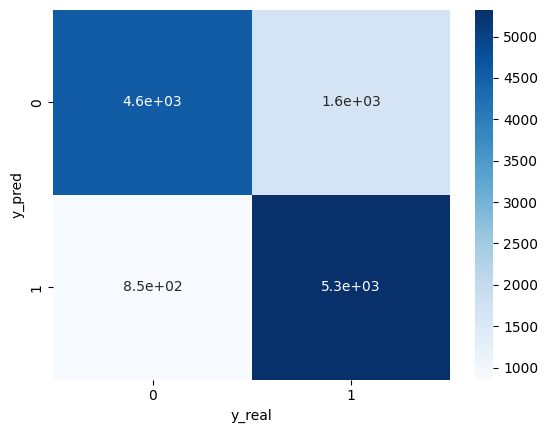

In [36]:
y_predic_ej1 = modelo1.predict(x_test_norm)
y_predic_cat_ej1 = np.where(y_predic_ej1>0.4,1,0)

ds_validacion=pd.DataFrame(y_predic_cat_ej1,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      6207
           1       0.76      0.86      0.81      6175

    accuracy                           0.80     12382
   macro avg       0.80      0.80      0.80     12382
weighted avg       0.80      0.80      0.80     12382



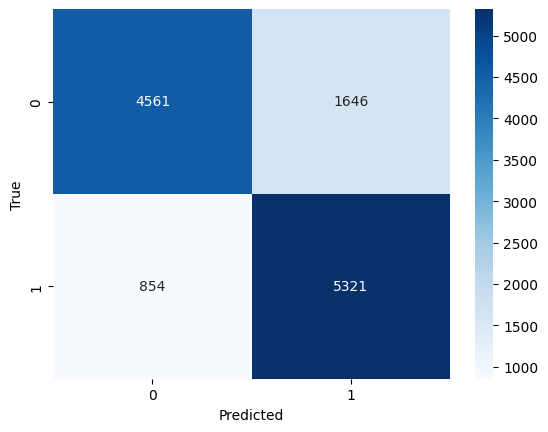

In [37]:
metricas(y_predic_cat_ej1,y_test)

Otra red

In [71]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))

d_in=len(x_train.columns)
modelo2 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 3 salidas, activación relu
    keras.layers.Dense(760,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(1, activation='sigmoid')])

modelo2.summary()
cant_clases

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 760)               57760     
                                                                 
 dense_29 (Dense)            (None, 1)                 761       
                                                                 
Total params: 58,521
Trainable params: 58,521
Non-trainable params: 0
_________________________________________________________________


2

In [72]:
modelo2.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2= 0.999), 
  loss='binary_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['AUC'], 
)

cant_epochs=100

historia_modelo2=modelo2.fit(x_train_norm,y_train,epochs=cant_epochs,batch_size=16,verbose=False)

In [73]:
y_predic_ej1 = modelo2.predict(x_test_norm)
y_predic_cat_ej1 = np.where(y_predic_ej1>0.5,1,0)

387/387 [==============================] - 0s 930us/step


In [65]:
y_predic_ej1

array([[0.99805534],
       [0.5491246 ],
       [0.26710814],
       ...,
       [0.02194417],
       [0.99947745],
       [0.198781  ]], dtype=float32)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      6207
           1       0.85      0.82      0.84      6175

    accuracy                           0.84     12382
   macro avg       0.84      0.84      0.84     12382
weighted avg       0.84      0.84      0.84     12382



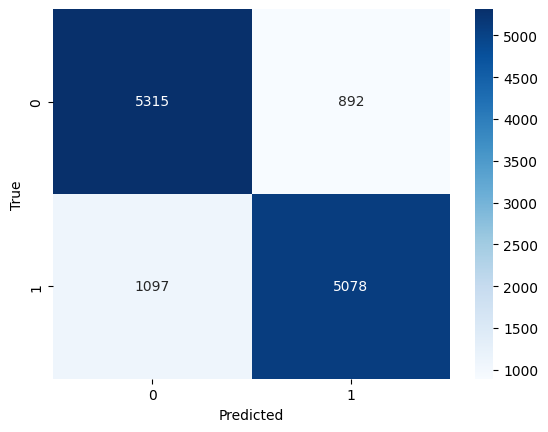

In [74]:
metricas(y_predic_cat_ej1,y_test)

Otra red

In [16]:
# calcula la cantidad de clases
cant_clases=len(np.unique(y_train))

d_in=len(x_train.columns)
modelo2 = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 1 salida, activación relu
    keras.layers.Dense(20,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(20,activation='relu'),
    keras.layers.Dense(20,activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])

modelo2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 20)                1520      
                                                                 
 dense_8 (Dense)             (None, 20)                420       
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,381
Trainable params: 2,381
Non-trainable params: 0
_________________________________________________________________


In [26]:
modelo2.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2= 0.999), 
  loss='binary_crossentropy', 
  # metricas para ir calculando en cada iteracion o batch 
  metrics=['accuracy'], 
)

cant_epochs=30

historia_modelo2=modelo2.fit(x_train_norm,y_train,epochs=cant_epochs,batch_size=16,verbose=False)

387/387 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      6207
           1       0.85      0.86      0.86      6175

    accuracy                           0.86     12382
   macro avg       0.86      0.86      0.86     12382
weighted avg       0.86      0.86      0.86     12382



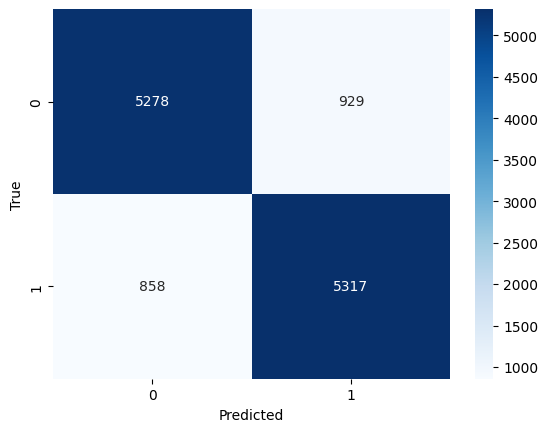

In [27]:
y_predic_ej1 = modelo2.predict(x_test_norm)
y_predic_cat_ej1 = np.where(y_predic_ej1>0.5,1,0)
metricas(y_predic_cat_ej1,y_test)

In [28]:
y_predic_ej1 = modelo2.predict(ds_test_filtrado_norm)
y_prediccion = np.where(y_predic_ej1>0.5,1,0)

830/830 [==============================] - 2s 2ms/step


In [29]:
guardar_prediccion(y_prediccion, ds_test, "predict_red_4c.csv")

In [32]:
guardar_modelo(modelo2, 'model_red_4c.sav')

In [79]:
# Create the sklearn model for the network

def create_model():
    modelo= keras.Sequential([
    keras.layers.Dense(10,input_shape=(d_in,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(1, activation='sigmoid')])
    
    modelo.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.001), 
      loss='binary_crossentropy', 
      # metricas para ir calculando en cada iteracion o batch 
      metrics=['AUC'], 
    )
    
    return modelo

Red con cross validation

In [80]:
from keras.wrappers.scikit_learn import KerasClassifier
modelo_cv = KerasClassifier(build_fn=create_model)

In [81]:
from sklearn.model_selection import GridSearchCV

epochs = [50, 100, 150]
batches = [5, 10, 20]

param_grid = dict( epochs=epochs, batch_size=batches)

print(param_grid)

grid = GridSearchCV(estimator=modelo_cv, param_grid=param_grid)
grid_result = grid.fit(x_train_norm, y_train)

{'epochs': [50, 100, 150], 'batch_size': [5, 10, 20]}
Epoch 1/50
7925/7925 [==============================] - 8s 1ms/step - loss: 0.5253 - auc: 0.8310
Epoch 2/50
7925/7925 [==============================] - 8s 992us/step - loss: 0.4320 - auc: 0.8811
Epoch 3/50
7925/7925 [==============================] - 8s 1ms/step - loss: 0.4054 - auc: 0.8930
Epoch 4/50
7925/7925 [==============================] - 8s 1ms/step - loss: 0.3924 - auc: 0.8993
Epoch 5/50
7925/7925 [==============================] - 9s 1ms/step - loss: 0.3840 - auc: 0.9037
Epoch 6/50
7925/7925 [==============================] - 8s 1ms/step - loss: 0.3775 - auc: 0.9070
Epoch 7/50
7925/7925 [==============================] - 10s 1ms/step - loss: 0.3726 - auc: 0.9094
Epoch 8/50
7925/7925 [==============================] - 9s 1ms/step - loss: 0.3686 - auc: 0.9113
Epoch 9/50
7925/7925 [==============================] - 8s 1ms/step - loss: 0.3653 - auc: 0.9130
Epoch 10/50
7925/7925 [==============================] - 8s 1ms/step -